# **E-commerce Agentic RAG & Evaluation**
This notebook covers the end-to-end deployment and governance of a shopping assistant.

### **Core Components:**
* **RAG Setup**: ChromaDB with `products.json` catalog.
* **Multi-Tool Agent**: Orchestration via `product_search` and `product_comparison`.
* **LLM-as-a-Judge**: Evaluates RAG retrieval relevancy, correctness.

# Agentic RAG for E-commerce: Orchestration & Evaluation
This notebook demonstrates a production-grade Agentic RAG pipeline, featuring:
* **Dynamic Retrieval**: Tools that query a vector database on-demand.
* **Orchestration**: An agent that reasons through multi-step customer queries.
* **Multi-hop Reasoning**: Connecting disparate product specs to form complex answers.
* **Evaluations**: Using Arize Phoenix to log traces and run LLM-as-a-Judge relevancy checks.

In [ ]:
ARIZE_API_KEY=""
ARIZE_SPACE_ID=""
OPENAI_API_KEY=""






In [3]:
# --- 1. SETUP & TRACING ---
# !pip install -qqq arize-otel arize agno openai openinference-instrumentation-agno openinference-instrumentation-openai chromadb sentence-transformers arize-phoenix

import os
import json
from getpass import getpass
from datetime import datetime
from arize.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.instrumentation.agno import AgnoInstrumentor

os.environ["ARIZE_SPACE_ID"] = getpass("🔑 Arize Space ID: ")
os.environ["ARIZE_API_KEY"] = getpass("🔑 Arize API Key: ")
os.environ["OPENAI_API_KEY"] = getpass("🔑 OpenAI API Key: ")

model_id = "ecom-agent-eval-v4"
tracer_provider = register(
    space_id=os.getenv("ARIZE_SPACE_ID"),
    api_key=os.getenv("ARIZE_API_KEY"),
    project_name=model_id,
    set_global_tracer_provider=True
)
OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)
AgnoInstrumentor().instrument(tracer_provider=tracer_provider)

🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: ecom-agent-eval-v4
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



Now it’s time to make our `local_flavor` tool even smarter by giving it access to a rich database of travel destination insights. We’ll use ChromaDB as the vector database and a Sentence Transformer model to generate embeddings that allow the tool to find and retrieve the most relevant information.

In [ ]:
! pip install "numpy<2" torch "transformers<5" sentence-transformers chromadb

## **2. Knowledge Base & Vector DB**
We initialize ChromaDB using the `SentenceTransformerEmbeddingFunction` to avoid hardware acceleration errors.

In [4]:
import chromadb
import chromadb.utils.embedding_functions as ef
from sentence_transformers import SentenceTransformer

# 1. Mock Catalog Data
products = [
    {"product": "LiteProduct 1", "category": "Home Organization", "price": "$25", "rating": "4.5", "reviews": "120", "description": "Minimalist shelf.", "specs": "Plastic, 5kg limit"},
    {"product": "MaxProduct 2", "category": "Home Organization", "price": "$45", "rating": "4.8", "reviews": "85", "description": "Heavy duty organizer.", "specs": "Steel, 20kg limit"},
    {"product": "EcoBin", "category": "Waste Management", "price": "$15", "rating": "4.2", "reviews": "50", "description": "Recycled bin.", "specs": "10L"}
]

# 2. Initialize Chroma with explicit Embedding Function
emb_func = ef.SentenceTransformerEmbeddingFunction(model_name='all-MiniLM-L6-v2')
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="ecom_catalog", embedding_function=emb_func)

collection.add(
    documents=[f"{p['product']} in {p['category']}: {p['description']}" for p in products],
    metadatas=products,
    ids=[f"id_{i}" for i in range(len(products))]
)

2026-02-20 23:27:35.356058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from sentence_transformers import SentenceTransformer
import chromadb.utils.embedding_functions as ef

model = SentenceTransformer('all-MiniLM-L6-v2')

emb_func = ef.SentenceTransformerEmbeddingFunction(model_name='all-MiniLM-L6-v2')

chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(
    name="ecommerce_products",
    embedding_function=emb_func  # <--- CRITICAL STEP
)

def load_and_index_products():
    """Load and index e-commerce products into ChromaDB"""
    with open('ecommerce_products.json', 'r') as f:
        products = json.load(f)
    
    documents = []
    metadatas = []
    ids = []
    
    for i, product in enumerate(products):
        # Create rich text representation for embedding
        text = f"Product: {product['product']}. Category: {product['category']}. Description: {product['description']}. Specs: {product['specs']}. Price: {product['price']}. Rating: {product['rating']}."
        
        documents.append(text)
        metadatas.append({
            "product": product["product"],
            "category": product["category"],
            "description": product["description"],
            "specs": product["specs"],
            "price": product["price"],
            "rating": product["rating"],
            "reviews": product["reviews"]
        })
        ids.append(f"product_{i}")
    
    # Add to ChromaDB collection
    collection.add(
        documents=documents,
        metadatas=metadatas,
        ids=ids
    )
    
    print(f"✅ Indexed {len(documents)} products in vector database")
    return len(documents)

In [ ]:
# Load the data
num_products = load_and_index_products()

## **3. Define Tools & Agent**
Implementing your specific `product_search` and `product_comparison` tools.

In [10]:
from agno.tools import tool
from opentelemetry import trace
from openinference.semconv.trace import SpanAttributes
from agno.agent import Agent
from agno.models.openai import OpenAIChat

tracer = trace.get_tracer(__name__)

@tool
def product_search(query: str, category: str = None) -> str:
    """Search for products using semantic similarity from vector database"""
    with tracer.start_as_current_span(name="RAG", attributes={SpanAttributes.OPENINFERENCE_SPAN_KIND: "retriever"}) as span:
        search_query = f"{query} {category or ''}".strip()
        span.set_attribute(SpanAttributes.INPUT_VALUE, search_query)
        results = collection.query(query_embeddings=embedding_model.encode([search_query]), n_results=3)
        
        if not results or not results.get("documents"):
            return "No matching products found."
        
        retrieved_docs = results["documents"][0]
        retrieved_meta = results["metadatas"][0]
        
        products_found = []
        for doc, meta in zip(retrieved_docs, retrieved_meta):
            span.set_attribute(f"retrieval.documents.{len(products_found)}.document.content", doc)
            product_info = f"**{meta['product']}** | {meta['price']} | {meta['rating']}★ | {meta['description']}"
            products_found.append(product_info)
        
        response = "Found matching products:\n" + "\n".join(products_found)
        span.set_attribute(SpanAttributes.OUTPUT_VALUE, response)
        return response

@tool
def product_comparison(products: str) -> str:
    """Compare multiple products based on features and pricing"""
    product_list = [p.strip() for p in products.split(',')]
    comparison = "Product Comparison:\n\n"
    for name in product_list:
        results = collection.query(query_embeddings=embedding_model.encode([name]), n_results=1)
        if results["metadatas"] and results["metadatas"][0]:
            meta = results["metadatas"][0][0]
            comparison += f"**{meta['product']}**: {meta['price']} | {meta['rating']}★ | {meta['specs']}\n"
    return comparison

ecommerce_agent = Agent(
    name="EcommerceQA",
    role="AI E-commerce Assistant",
    model=OpenAIChat(id="gpt-4o"),
    instructions=[
        "Use product_search for discovery and product_comparison for comparisons.",
        "Recommend based on needs, highlight pricing and ratings.",
        "Keep responses under 800 words."
    ],
    tools=[product_search, product_comparison],
    markdown=True
)

# Execution
query = "Recommend products for home organization under $50. Also compare LiteProduct 1 vs MaxProduct 2."
ecommerce_agent.run(query)

RunOutput(run_id='04b262c3-4c17-4c8c-a3cc-a59e8d6abc25', agent_id='ecommerceqa', agent_name='EcommerceQA', session_id='9fa4782e-0ec5-4ea0-b010-a9234ab9d95b', parent_run_id=None, workflow_id=None, user_id=None, input=RunInput(input_content='Recommend products for home organization under $50. Also compare LiteProduct 1 vs MaxProduct 2.', images=None, videos=None, audios=None, files=None), content="### Home Organization Products Under $50\n\nHere are some recommended home organization products you might find useful, all within your budget of $50:\n\n1. **Stackable Storage Bins**\n   - **Price:** $25\n   - **Features:** Clear, stackable bins that are great for a variety of items, from toys to office supplies.\n   - **Rating:** 4.7/5\n\n2. **Over-the-Door Shoe Organizer**\n   - **Price:** $19.99\n   - **Features:** Comes with 24 pockets, perfect for shoes, kids' toys, and other smaller essentials.\n   - **Rating:** 4.5/5\n\n3. **Closet Hanging Organizer**\n   - **Price:** $15\n   - **Featur

## 3. Execution & Multi-hop Reasoning
The query below requires the agent to find a product category, retrieve specific specs, and evaluate them against a battery requirement.

In [ ]:
ecommerce_agent.run("Recommend tablets or smartphones for media consumption under $450 with at least 40h battery?")

In [6]:
print("🤖 E-commerce Q&A Agent Ready!")
ecommerce_agent.print_response(query, stream=True)

🤖 E-commerce Q&A Agent Ready!


Output()

## Agent Evals - System and Model Evals

# 

![Untitled 20.jpg](<attachment:Untitled 20.jpg>)
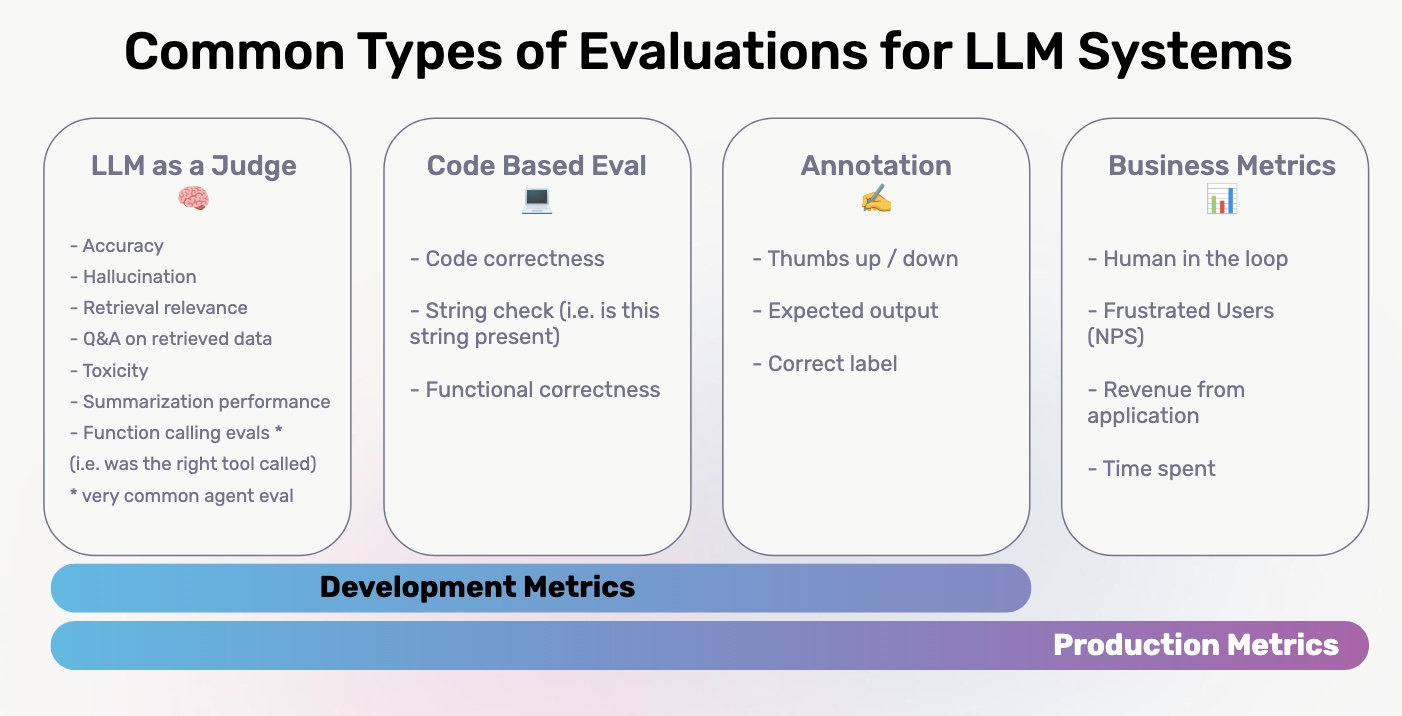

![Untitled 21.jpg](<attachment:Untitled 21.jpg>)
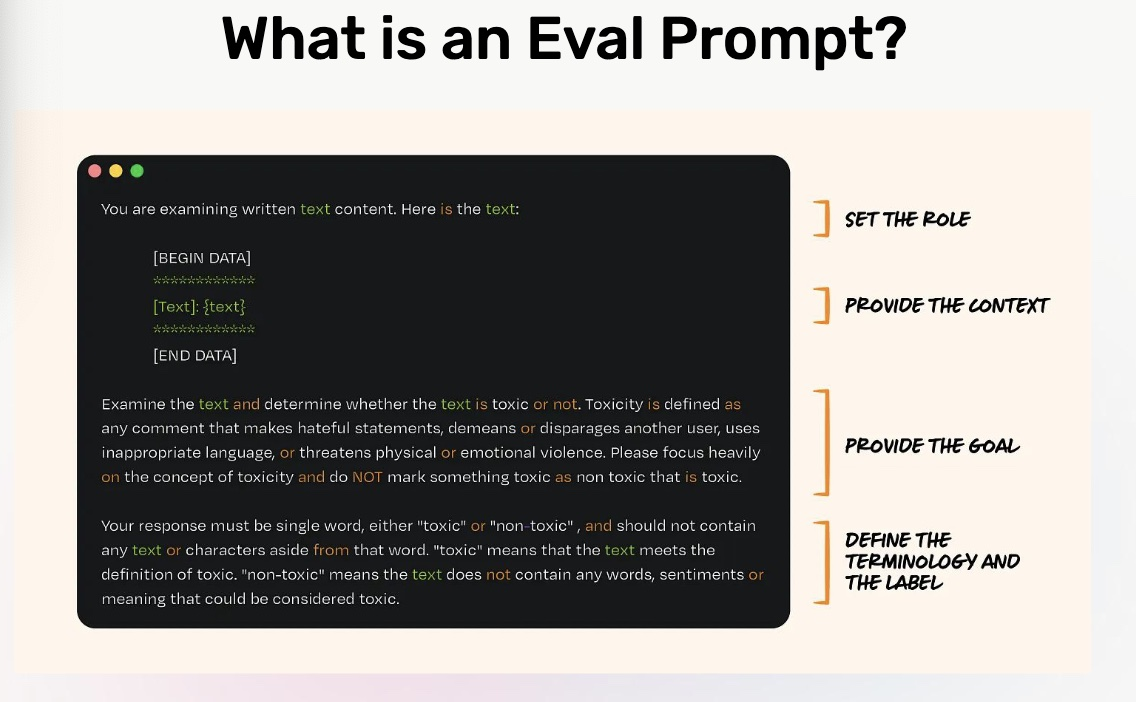

In [ ]:
queries = [
    "Recommend products for home organization under $50. Also compare LiteProduct 1 vs MaxProduct 2",
    "Suggest the best smart home devices under $200. Prioritize locks and thermostats with ratings above 4.5",
    "Find top audio devices with active noise cancellation under $150 and at least 100 reviews",
    "Recommend laptops or desktops for heavy multitasking with SSD > 1TB and rating above 4.5",
    "Show fitness equipment for home workouts under $400, and compare UltraBike 19 vs EssentialBike 69",
    "List eco-friendly products across any category under $60 and sort by rating",
    "Recommend tablets or smartphones for media consumption under $450 with at least 40h battery",
    "Find premium projectors for home theater under $700 and explain differences between MaxProjector 68, SmartProjector 15, and PremiumProjector 16",
    "Suggest beauty kits or tools under $50 for daily routines with ratings above 4.3",
    "Recommend wearable accessories for everyday use under $80, focusing on PremiumAccessory 32 and MaxAccessory 97",
    "Find smart locks and cameras for an apartment security setup under $300 total budget",
    "Recommend beginner-friendly books related to kits and tools under $30 and at least 40 reviews",
    "Suggest audio products suitable for long battery life (≥40h) under $200",
    "Find computing devices (laptops, desktops, workstations, servers) sorted by price-to-RAM value",
    "Recommend a starter home office setup with one computing device, one peripheral kit, and one office accessory, total under $1500"
]

In [11]:
queries = [
    "Recommend products for home organization under $50. Also compare LiteProduct 1 vs MaxProduct 2",
    "Suggest the best smart home devices under $200. Prioritize locks and thermostats with ratings above 4.5"]

In [13]:
for q in queries:
  response = ecommerce_agent.run(q)

In [14]:

print('#### Installing arize SDK')

! pip install "arize[Tracing]>=7.1.0, <8.0.0"

print('#### arize SDK installed!')

import os

from datetime import datetime

from arize.exporter import ArizeExportClient
from arize.utils.types import Environments

client = ArizeExportClient()

print('#### Exporting your primary dataset into a dataframe.')



primary_df = client.export_model_to_df(
    space_id='U3BhY2U6MzgyNDg6V1Q0Lw==',
    model_id='ecom-agent-eval-v4',
    environment=Environments.TRACING,
    start_time=datetime.fromisoformat('2026-02-13T05:00:00.000+00:00'),
    end_time=datetime.fromisoformat('2026-02-21T04:59:59.999+00:00'),
    # Optionally specify columns to improve query performance
    # columns=['context.span_id', 'attributes.llm.input']
)

#### Installing arize SDK


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Attempting uninstall: requests-futures
    Found existing installation: requests-futures 1.0.2
    Uninstalling requests-futures-1.0.2:
      Successfully uninstalled requests-futures-1.0.2
  Attempting uninstall: arize
    Found existing installation: arize 8.2.1
    Uninstalling arize-8.2.1:
      Successfully uninstalled arize-8.2.1

[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
#### arize SDK installed!
  arize.utils.logging | INFO | Creating named session as 'python-sdk-arize_python_export_client-c7253f78-f4c3-4d03-91cb-88909eb05630'.
#### Exporting your primary dataset into a dataframe.
  arize.utils.logging | INFO | Fetching data...
  arize.utils.logging | INFO | Starting exporting...


  exporting 46 rows: 100%|█████████████████████████| 46/46 [00:00, 231.21 row/s]


In [16]:
primary_df.columns

Index(['attributes.llm.token_count.completion_details.output', 'event.names',
       'attributes.exception.type', 'attributes.llm.prompt_template.version',
       'attributes.retrieval.documents', 'parent_id',
       'attributes.llm.cost.completion_details.audio', 'time',
       'attributes.agno.agent', 'attributes.llm.token_count.prompt',
       'attributes.llm.cost.prompt', 'attributes.embedding.model_name',
       'attributes.llm.prompt_template.template', 'name',
       'attributes.openinference.span.kind', 'attributes.exception.stacktrace',
       'attributes.input.value', 'attributes.reranker.query',
       'attributes.llm.token_count.completion_details.audio',
       'attributes.llm.provider',
       'attributes.llm.cost.prompt_details.cache_read',
       'attributes.llm.cost.completion_details.reasoning',
       'attributes.llm.cost.completion_details.output',
       'attributes.llm.token_count.total', 'attributes.output.mime_type',
       'attributes.reranker.model_name',
    

In [17]:
RAG_RELEVANCY_PROMPT_TEMPLATE = """
You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {{input}}
    ************
    [Reference text]: {{documents}}
    ************
    [END DATA]
Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can help answer the Question. First, write out in a step by step manner
an EXPLANATION to show how to arrive at the correct answer. Avoid simply stating the correct answer
at the outset. Your response LABEL must be single word, either "relevant" or "unrelated", and
should not contain any text or characters aside from that word. "unrelated" means that the
reference text does not help answer to the Question. "relevant" means the reference text directly
answers the question.

Example response:
LABEL: "relevant" or "unrelated"
************
"""

In [18]:
spans_df = primary_df[
    [
        "name",
        "context.span_id",
        "attributes.openinference.span.kind",
        "context.trace_id",
        "attributes.input.value",
        "attributes.retrieval.documents",
    ]
]

In [23]:
filtered_df = spans_df[
    (spans_df["attributes.openinference.span.kind"] == "retriever")
    & (spans_df["attributes.retrieval.documents"].notnull())
]

filtered_df = filtered_df.rename(
    columns={"attributes.input.value": "input", "attributes.retrieval.documents": "documents"}
)

filtered_df

name   context.span_id attributes.openinference.span.kind  \
3  RAG  0390d509c7879064                          retriever   
9  RAG  b101ec77316ced40                          retriever   

                   context.trace_id                        input  \
3  15e205614934c48ad1f2d44a65aaa57f  home organization under $50   
9  df70b5d3c8f7f28863d774f450821922  home organization under $50   

                                           documents  
3  [{'document.content': 'MaxProduct 2 in Home Or...  
9  [{'document.content': 'MaxProduct 2 in Home Or...

In [24]:
from openinference.instrumentation import suppress_tracing
from phoenix.evals.evaluators import async_evaluate_dataframe
from phoenix.evals.llm import LLM
from phoenix.evals import create_classifier

llm = LLM(provider="openai", model="gpt-5")

relevancy_evaluator = create_classifier(
    name="RAG Relevancy",
    llm=llm,
    prompt_template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    choices={"relevant": 1.0, "unrelated": 0.0},
)

with suppress_tracing():
    results_df = await async_evaluate_dataframe(
        dataframe=filtered_df,
        evaluators=[relevancy_evaluator],
    )
results_df.head()

Evaluating Dataframe |          | 0/2 (0.0%) | ⏳ 00:00<? | ?it/s

name   context.span_id attributes.openinference.span.kind  \
3  RAG  0390d509c7879064                          retriever   
9  RAG  b101ec77316ced40                          retriever   

                   context.trace_id                        input  \
3  15e205614934c48ad1f2d44a65aaa57f  home organization under $50   
9  df70b5d3c8f7f28863d774f450821922  home organization under $50   

                                           documents  \
3  [{'document.content': 'MaxProduct 2 in Home Or...   
9  [{'document.content': 'MaxProduct 2 in Home Or...   

                     RAG Relevancy_execution_details  \
3  {'status': 'COMPLETED', 'exceptions': [], 'exe...   
9  {'status': 'COMPLETED', 'exceptions': [], 'exe...   

                                 RAG Relevancy_score  
3  {'name': 'RAG Relevancy', 'score': 0.0, 'label...  
9  {'name': 'RAG Relevancy', 'score': 0.0, 'label...

In [25]:
from arize.pandas.logger import Client
from phoenix.evals.utils import to_annotation_dataframe
import ast

import pandas as pd
client = Client()

rag_eval_df = to_annotation_dataframe(results_df)
rag_eval_df = rag_eval_df.rename(columns={
    "label": "eval.rag.label",
    "score": "eval.rag.score",
    "explanation": "eval.rag.explanation",
    "metadata": "eval.rag.metadata"
})

client.log_evaluations_sync(rag_eval_df, 'ecom-agent-eval-v4')

  arize.utils.logging | INFO | The following columns do not follow the evaluation column naming convention and will be ignored: eval.rag.metadata, annotation_name and annotator_kind. Evaluation columns must be named as follows: - eval.<your-eval-name>.label- eval.<your-eval-name>.score- eval.<your-eval-name>.explanation


/var/folders/77/0w3rw50s6_nc28qbf0hlwy2c0000gp/T/ipykernel_28427/1957919176.py:8: DeprecationWarning: Positional arguments for to_annotation_dataframe are deprecated and will be removed in a future version. Please use keyword arguments instead.
  rag_eval_df = to_annotation_dataframe(results_df)


  arize.utils.logging | INFO | ✅ All 2 evaluation data have been logged successfully for model 'ecom-agent-eval-v4'!


records_updated: 2

Click on the retriever spans within each trace to view detailed evaluation results. You can also filter by evaluation outcome to quickly identify which queries successfully retrieved the most relevant documents.

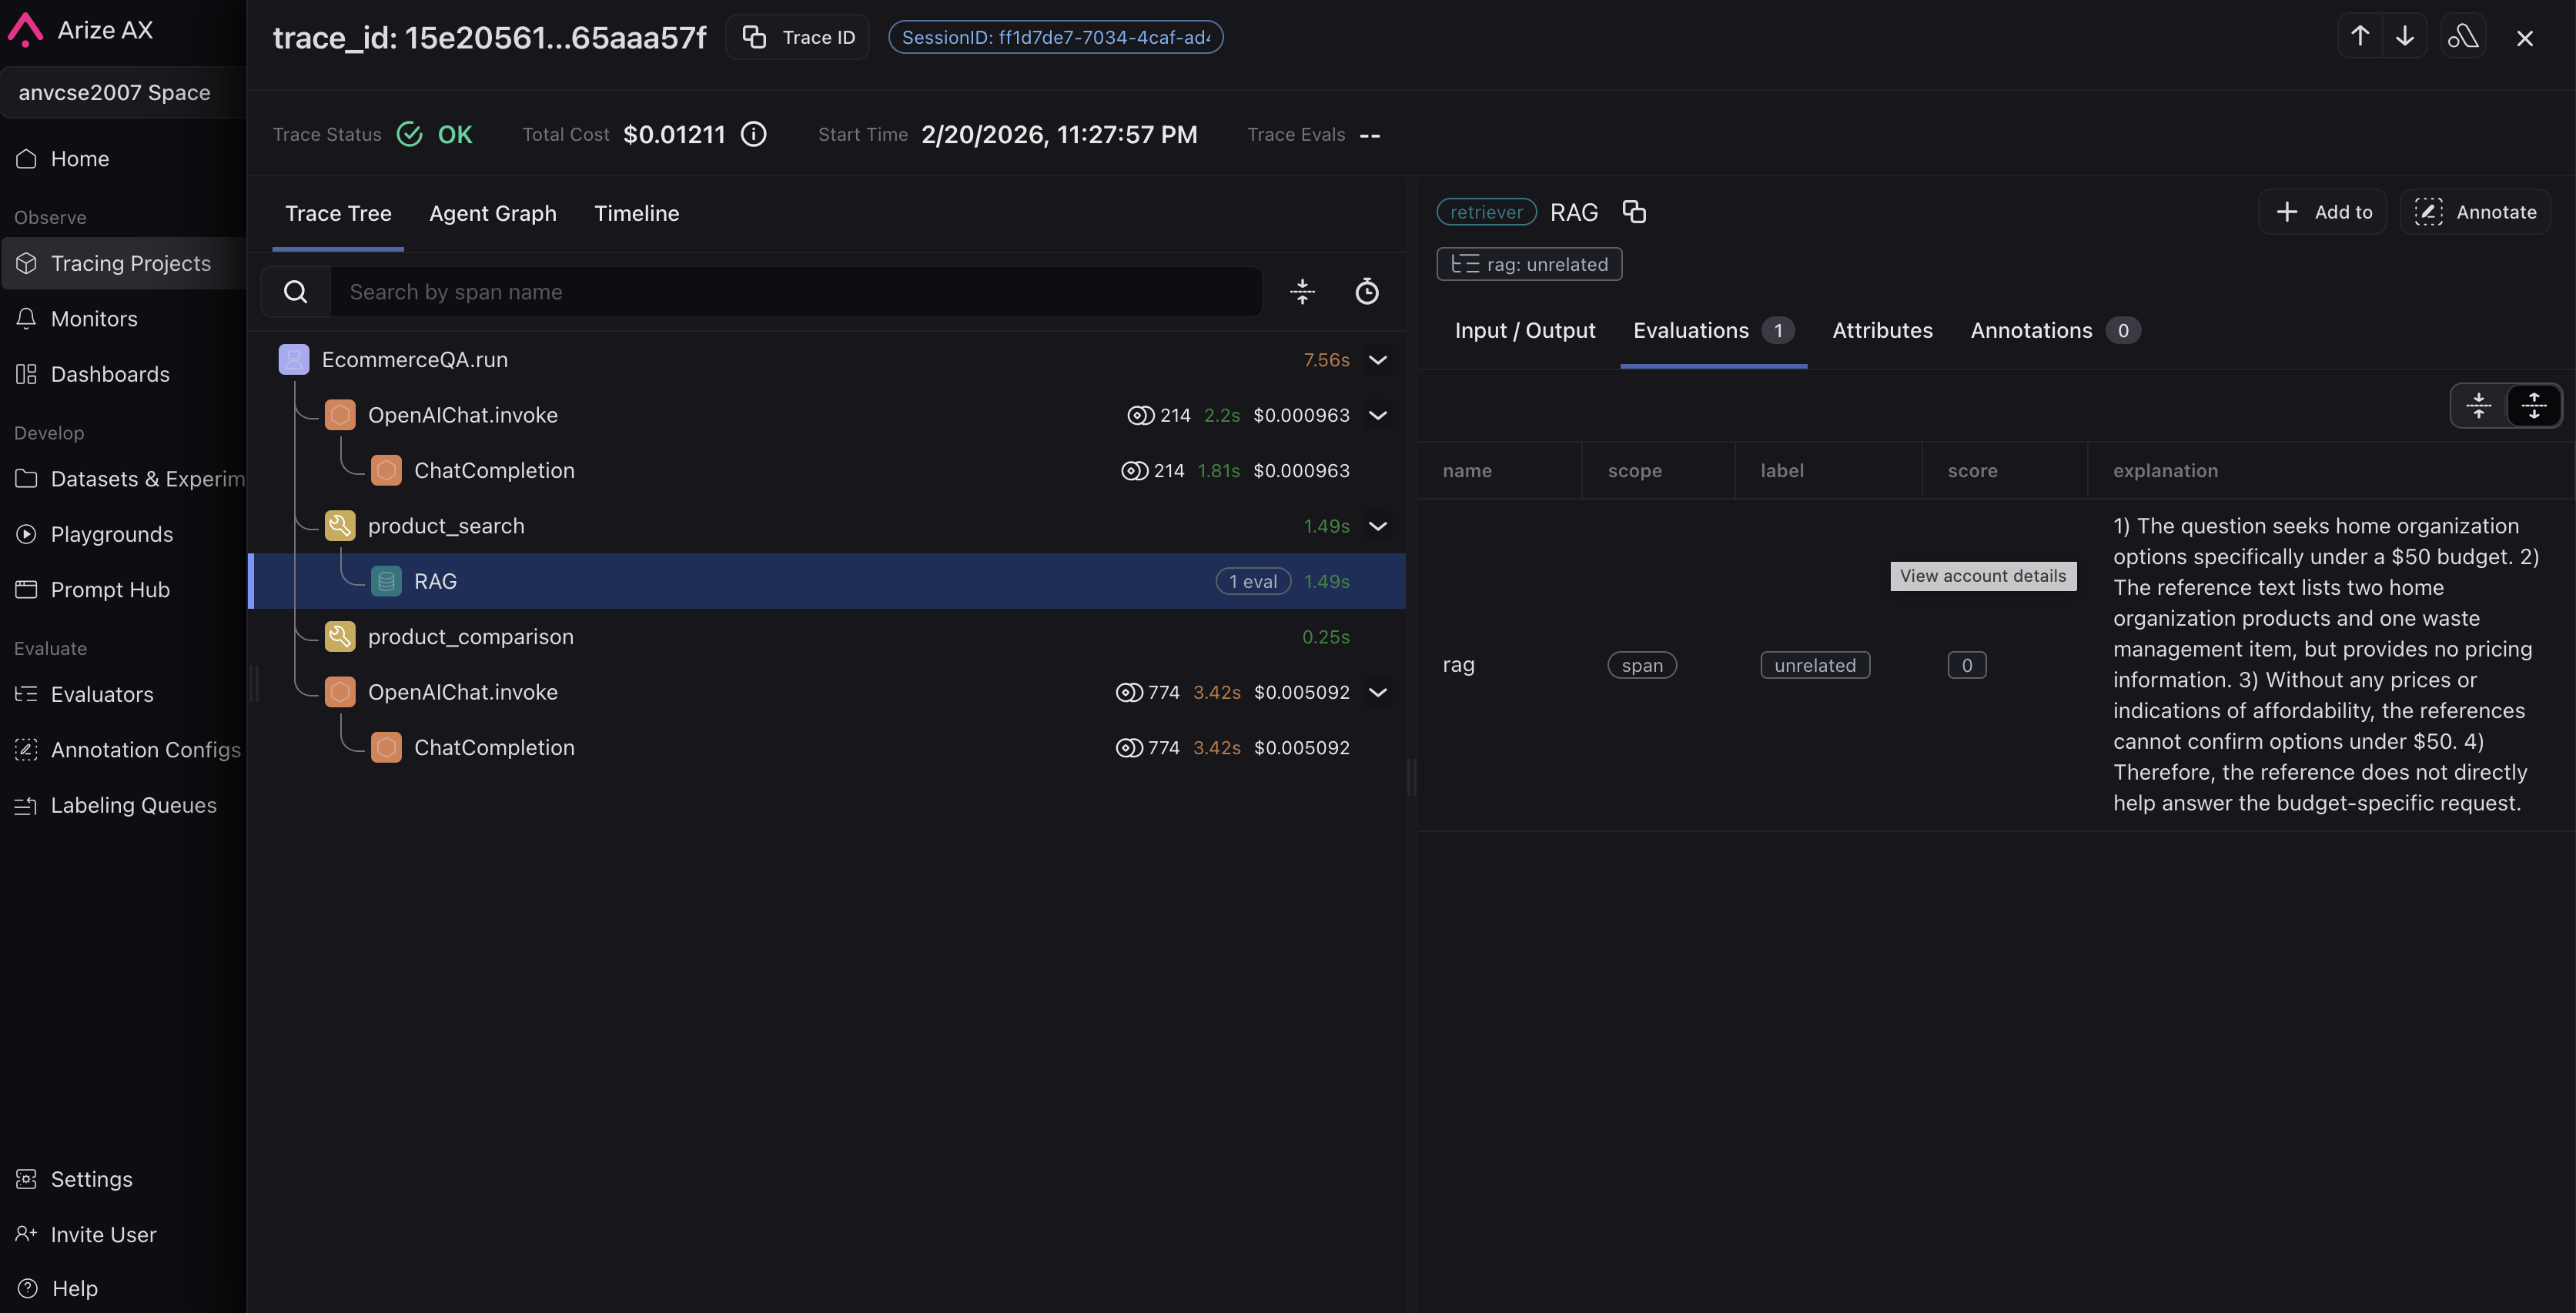

### In this section, we will walk you through how to set up and run evaluations in the Arize UI. Specifically, we will be running a trace level evaluation to determine the answer quality of our agent.

![Untitled 17.jpg](<attachment:Untitled 17.jpg>))
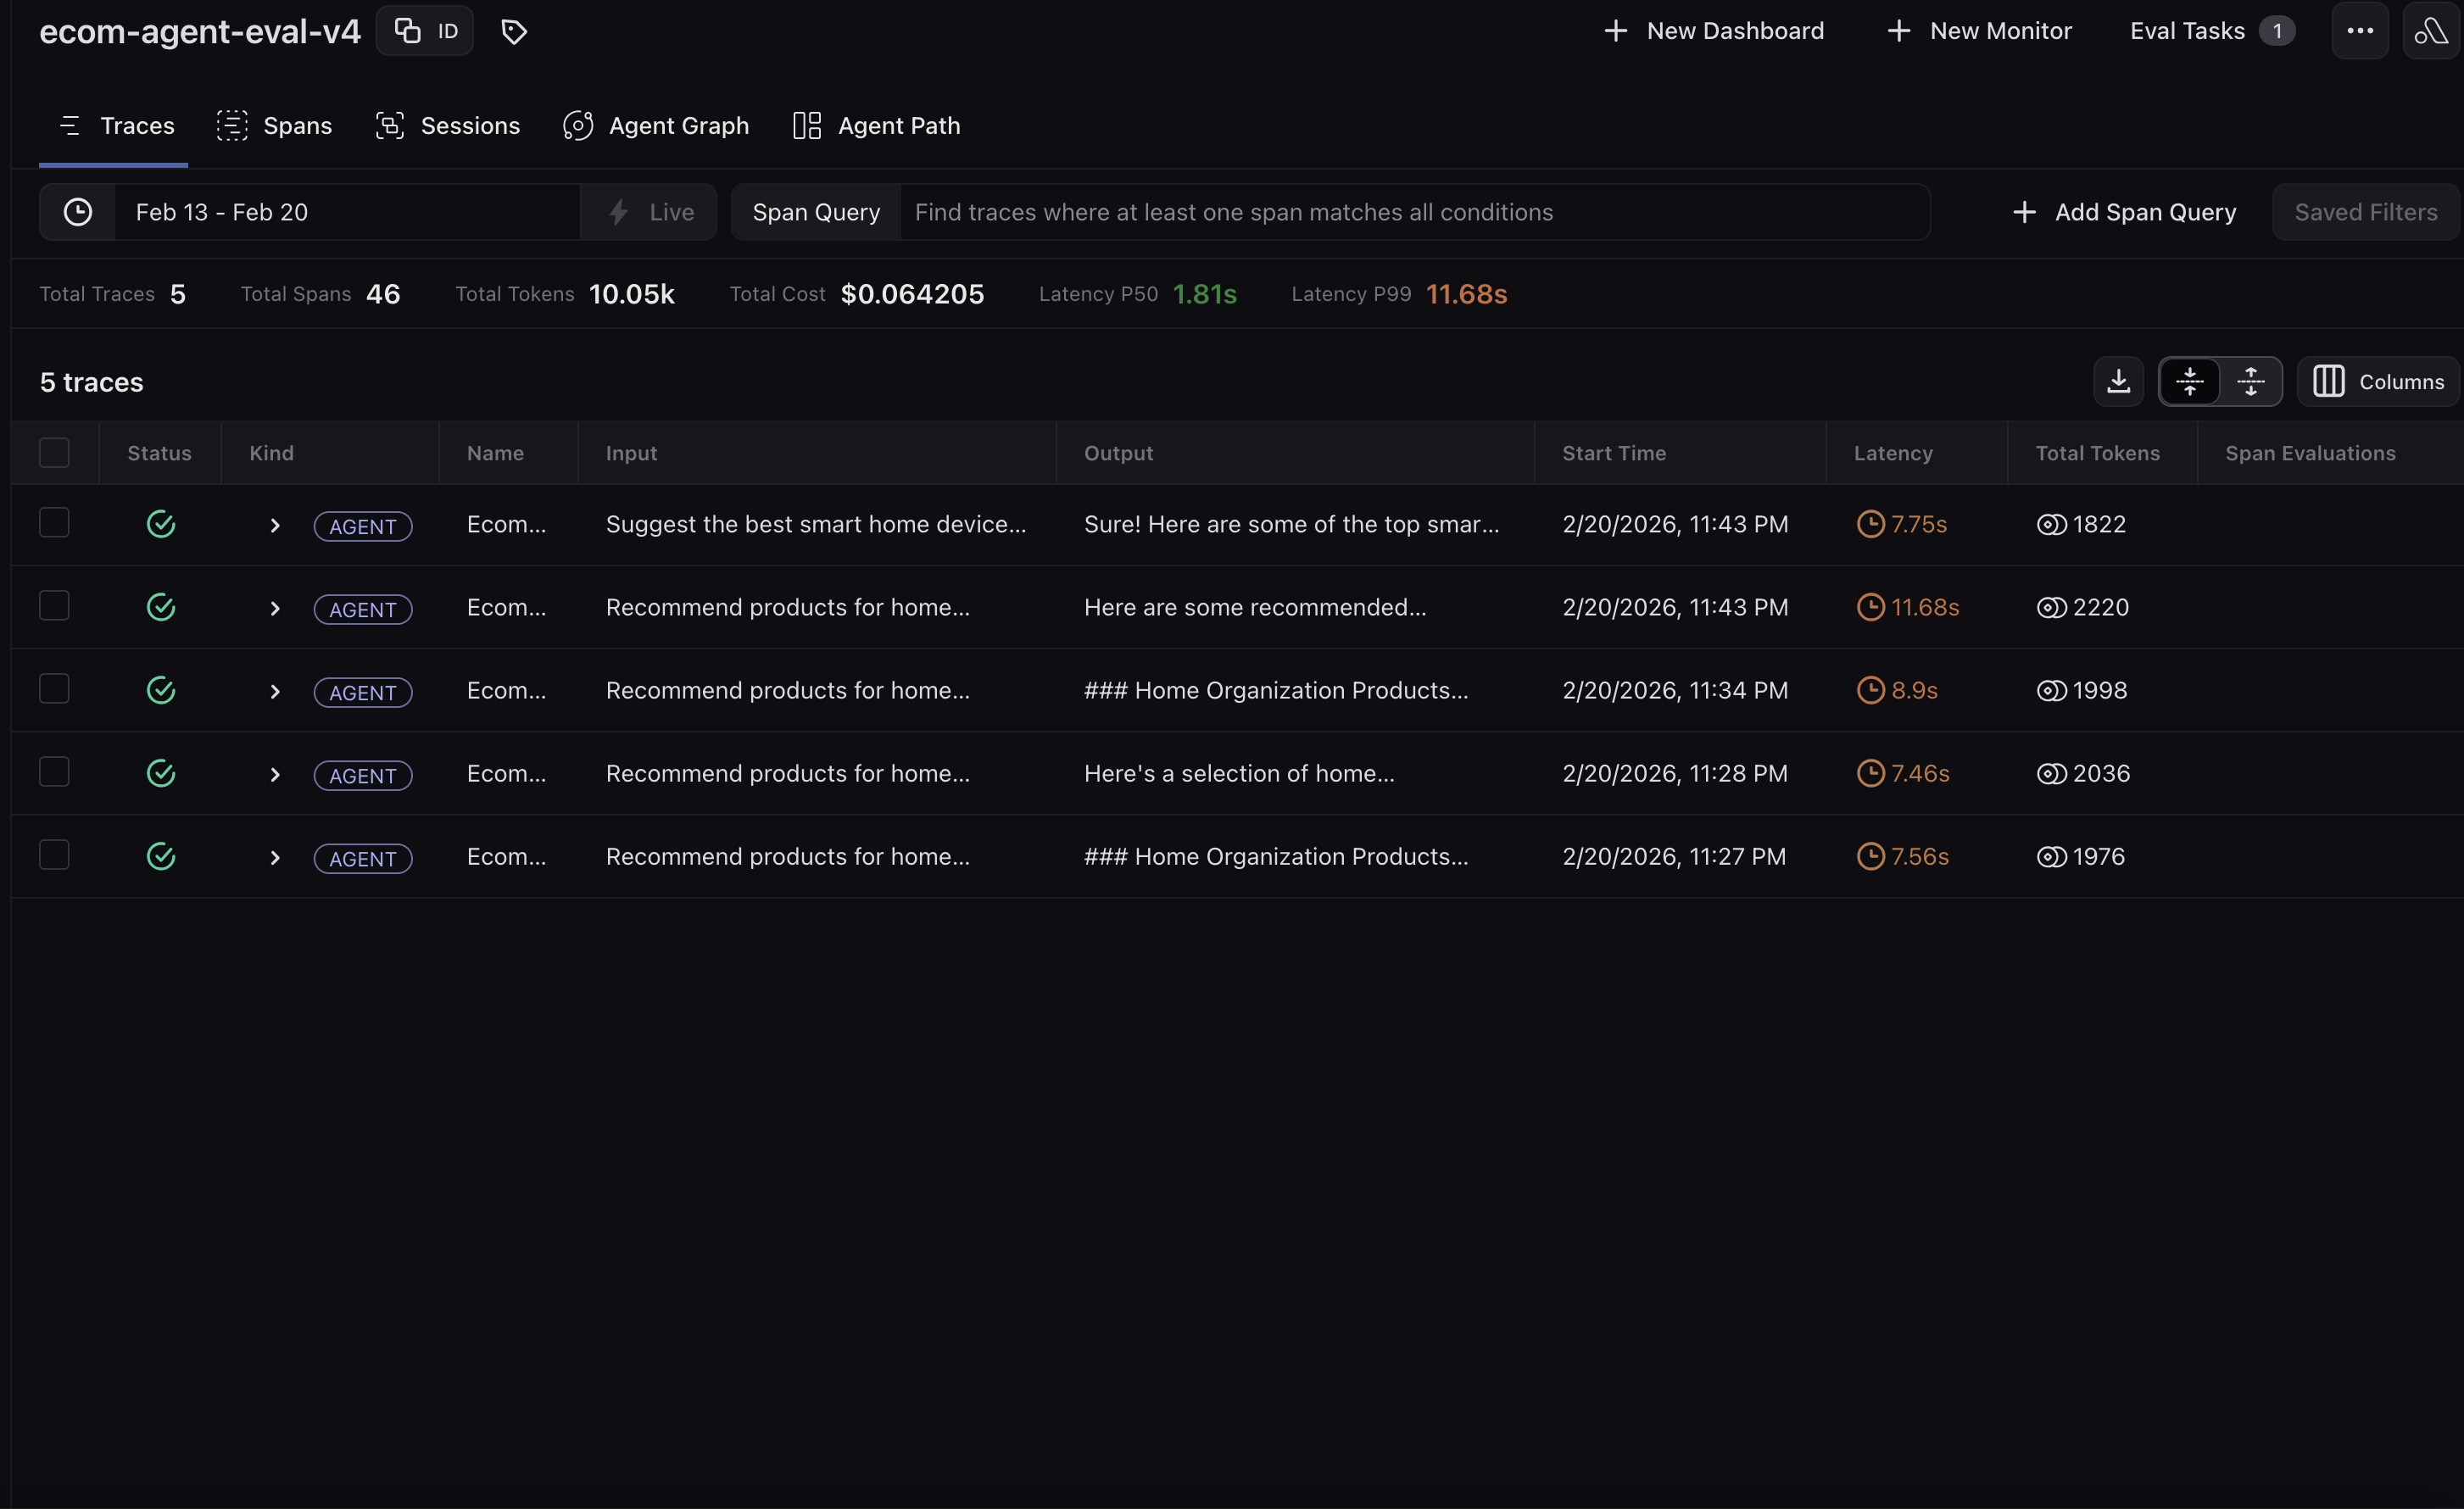

![Untitled 18.jpg](<attachment:Untitled 18.jpg>)
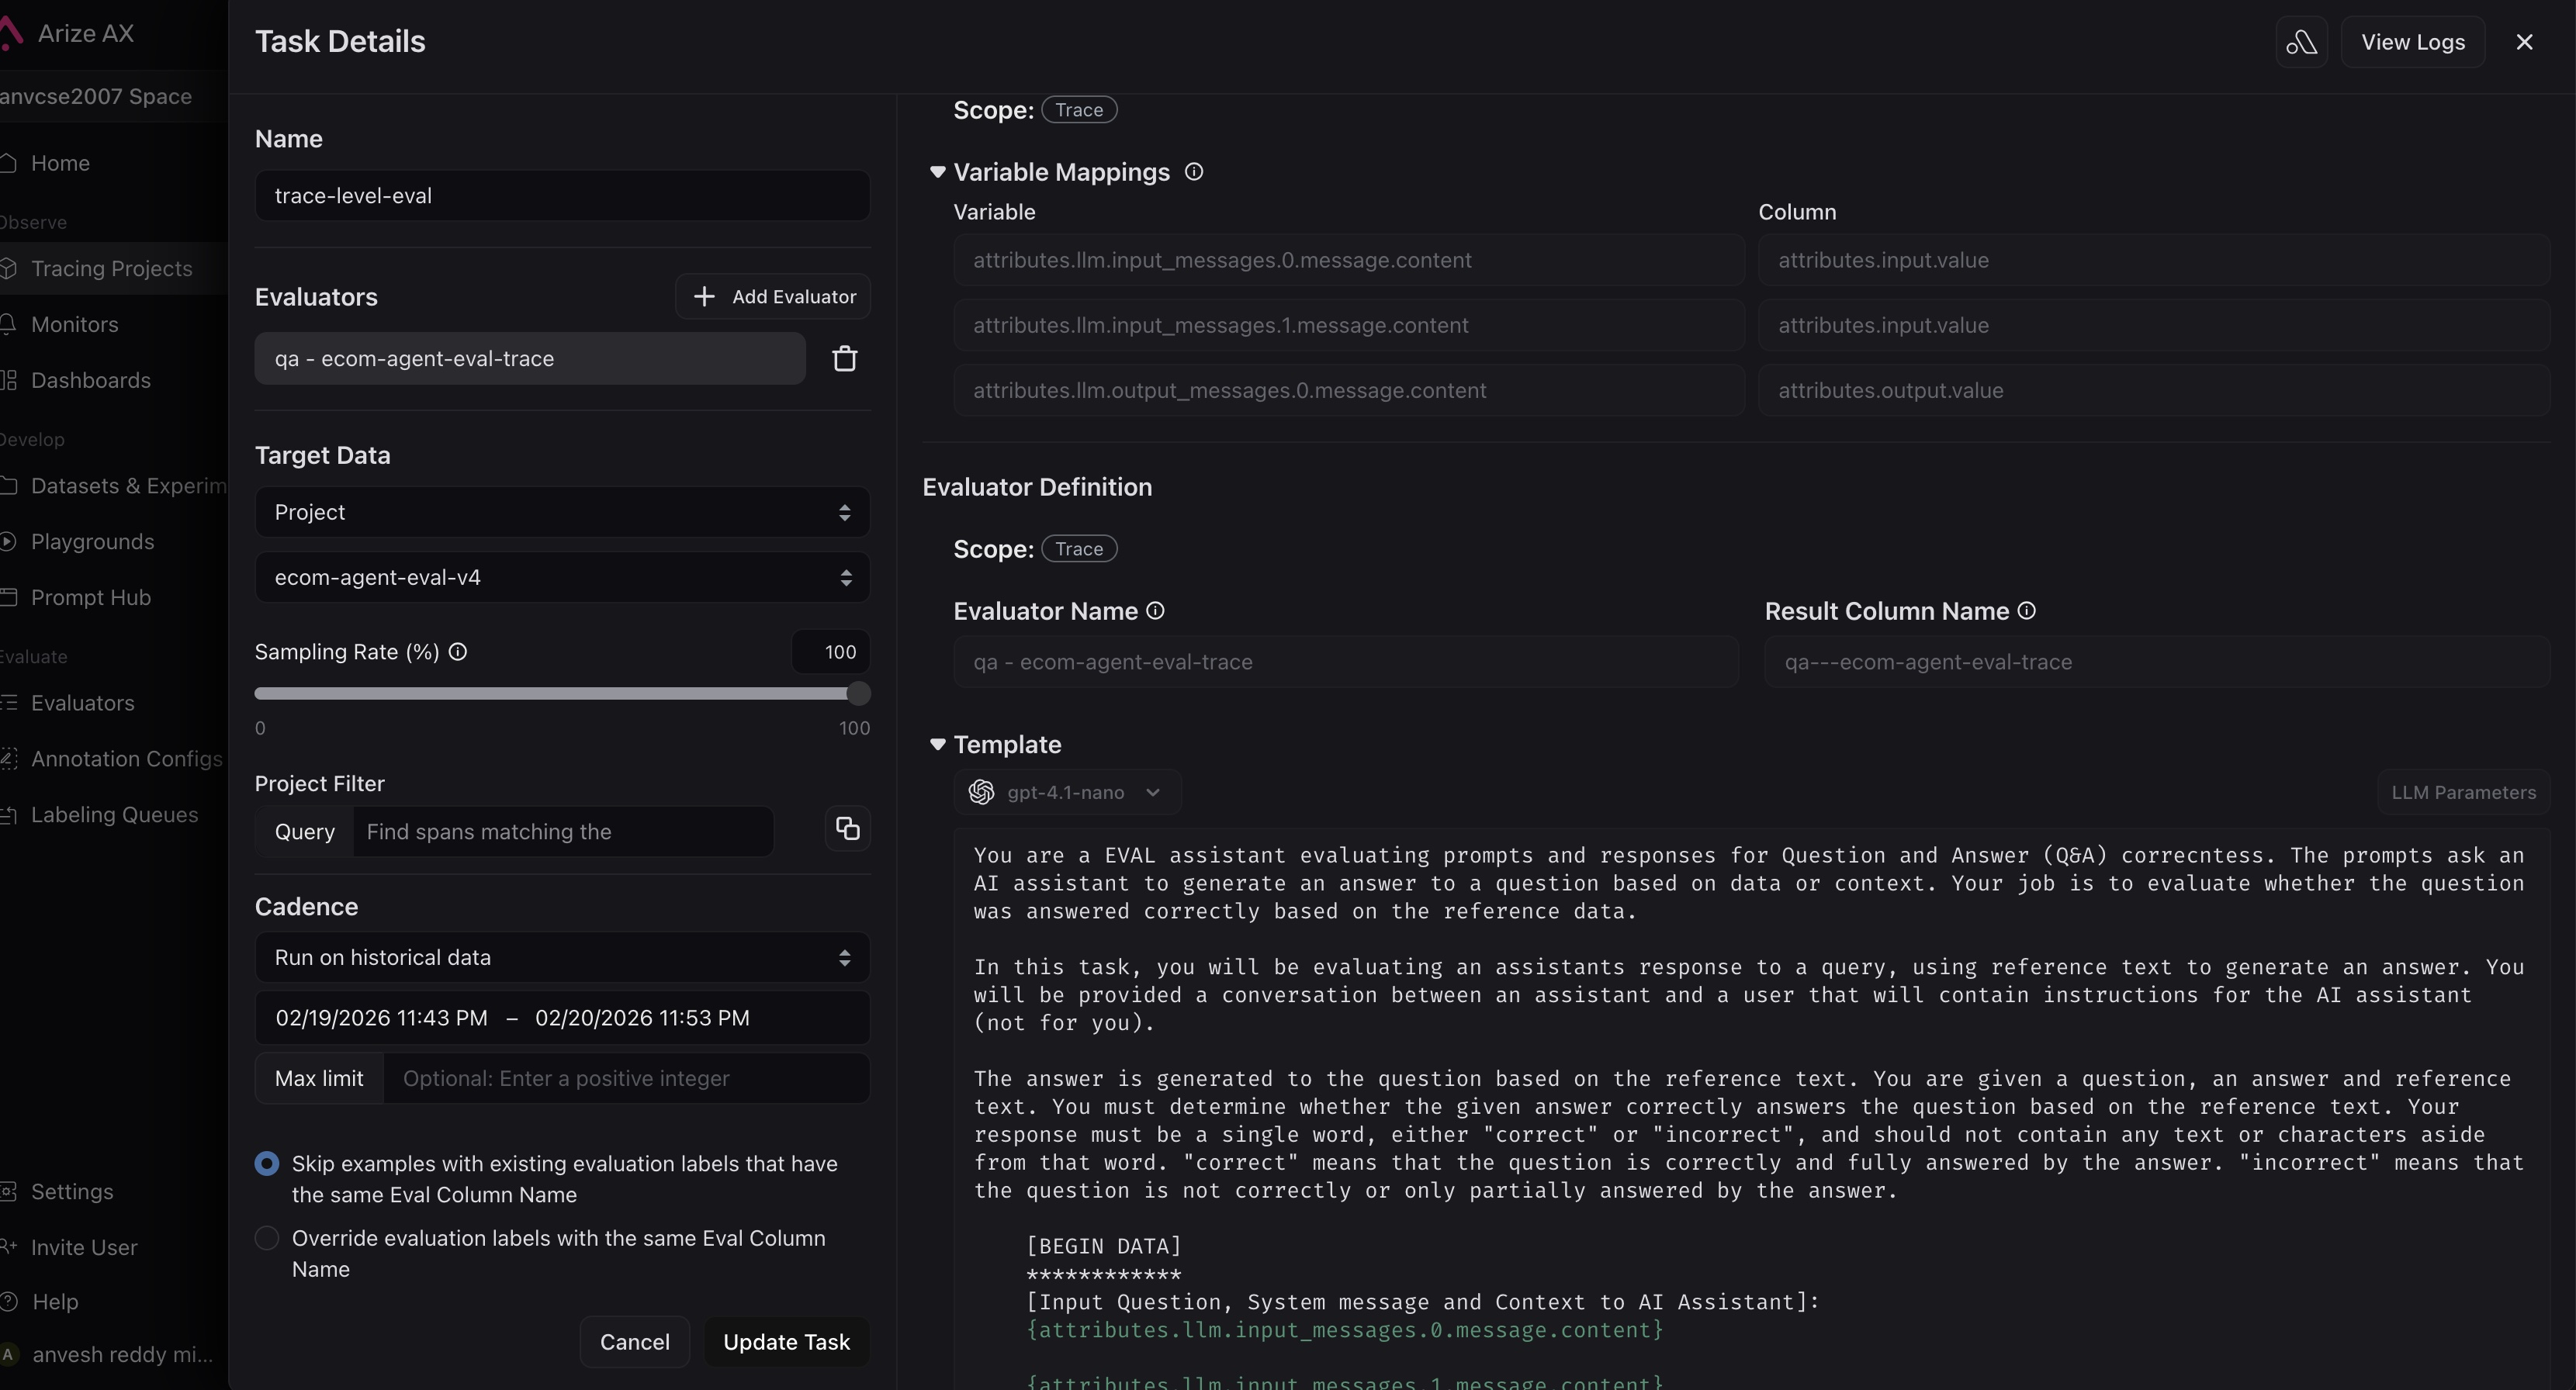

1. In the project containing your traces, go to Eval Tasks and select LLM as a Judge.

2. Name your task and schedule it to run on historical data. Each task can include multiple evaluators, but this walkthrough focuses on setting up one.

3. Choose a trace-level evaluation.

4. From the predefined templates, select Q&A or another template of your choice. You can also create a custom evaluation. If you define your own, ensure the variables align with your trace structure and specify the output labels (rails).

5. Click Create Evals. Your evaluations will begin running and will appear on your existing traces. Look for the eval result on the top span for each trace.

# Trace-Level Evaluation in the Arize UI

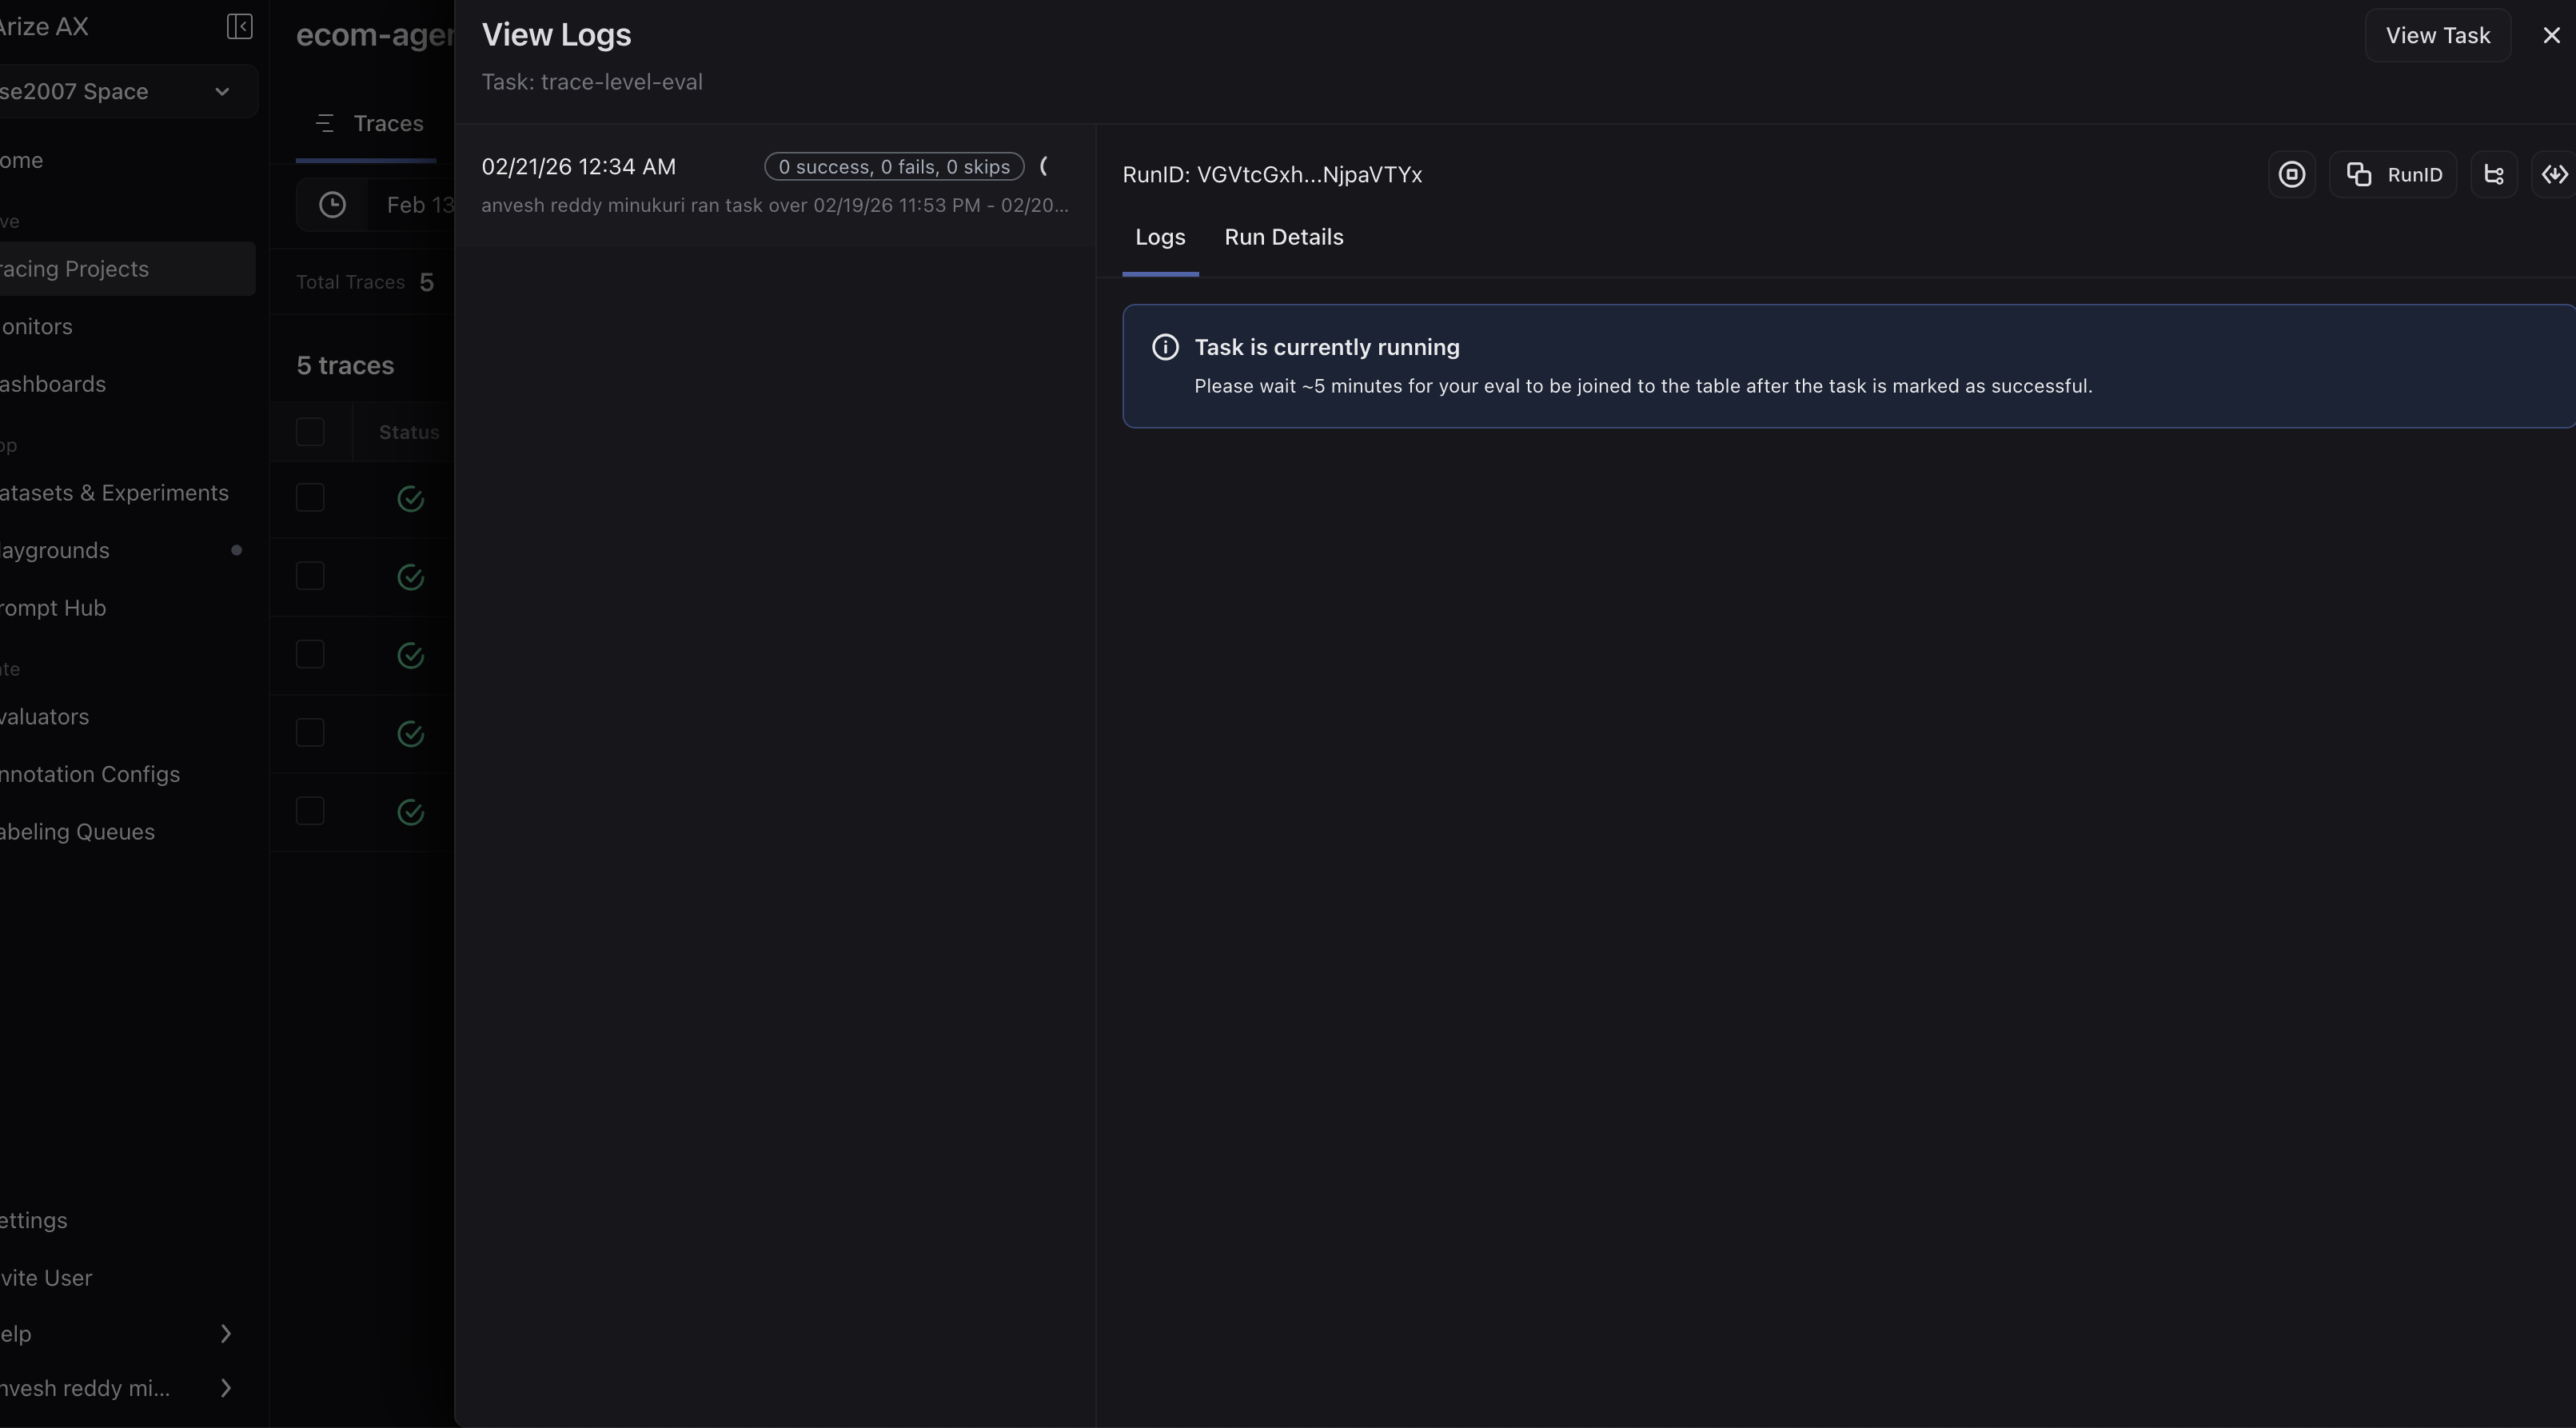

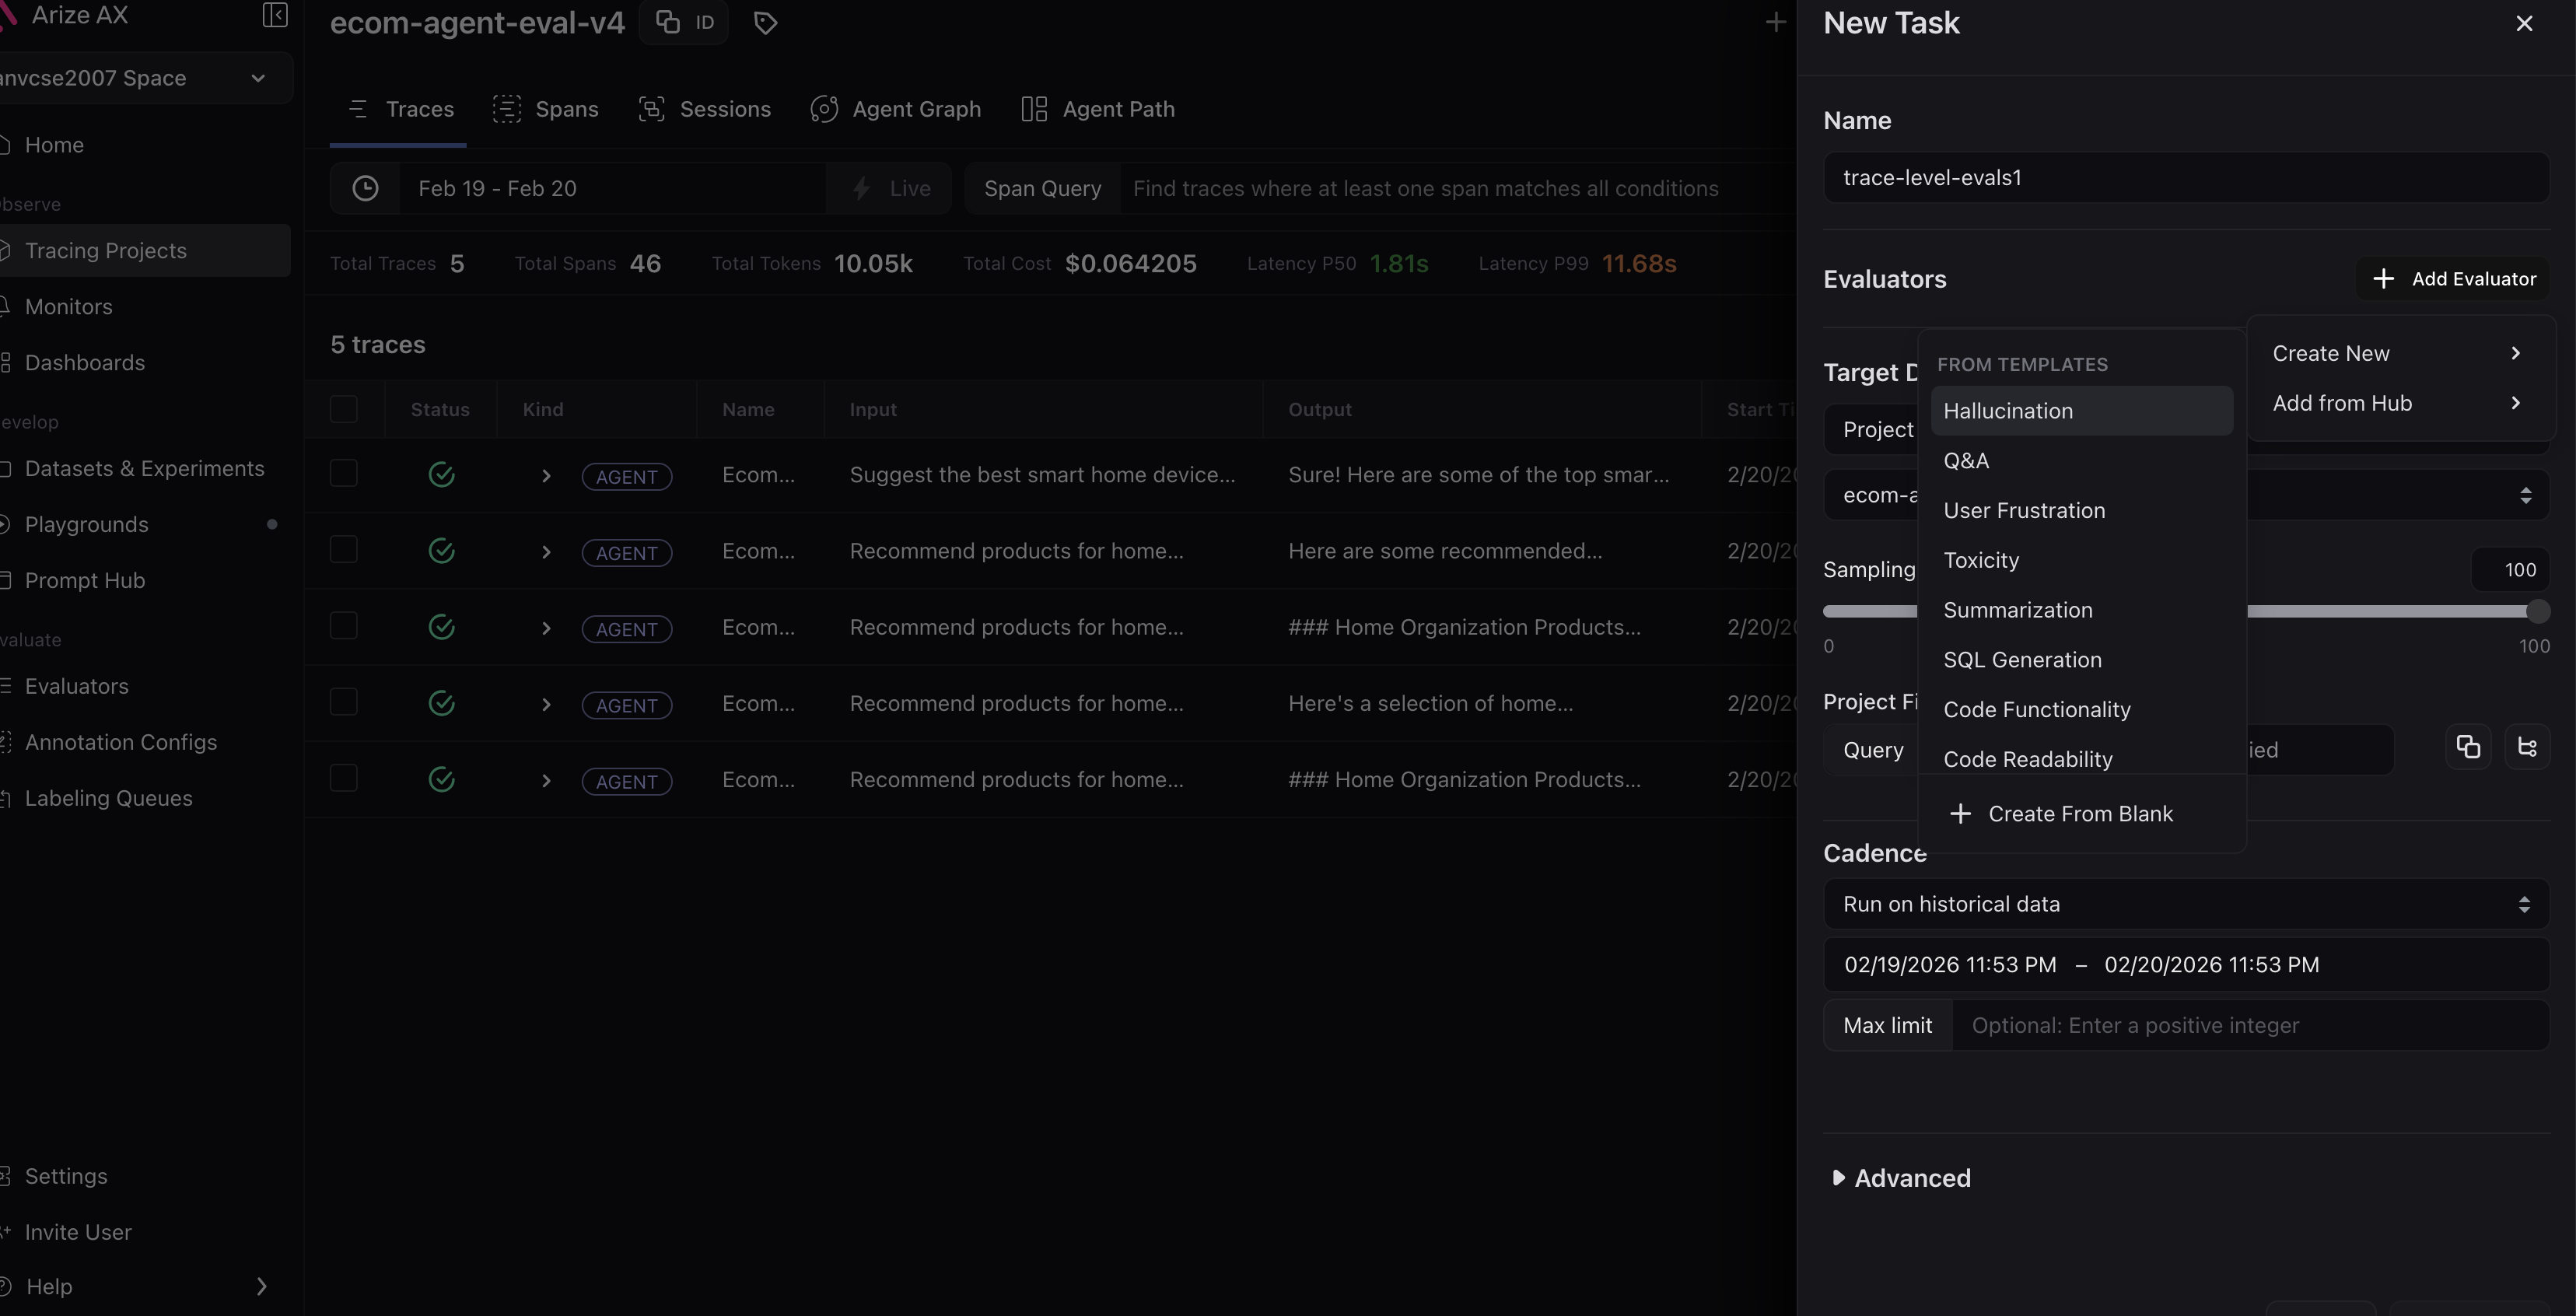

## **4. Multi-Layered Evaluation**
Updated evaluators for tool picking, response correctness, and tone.

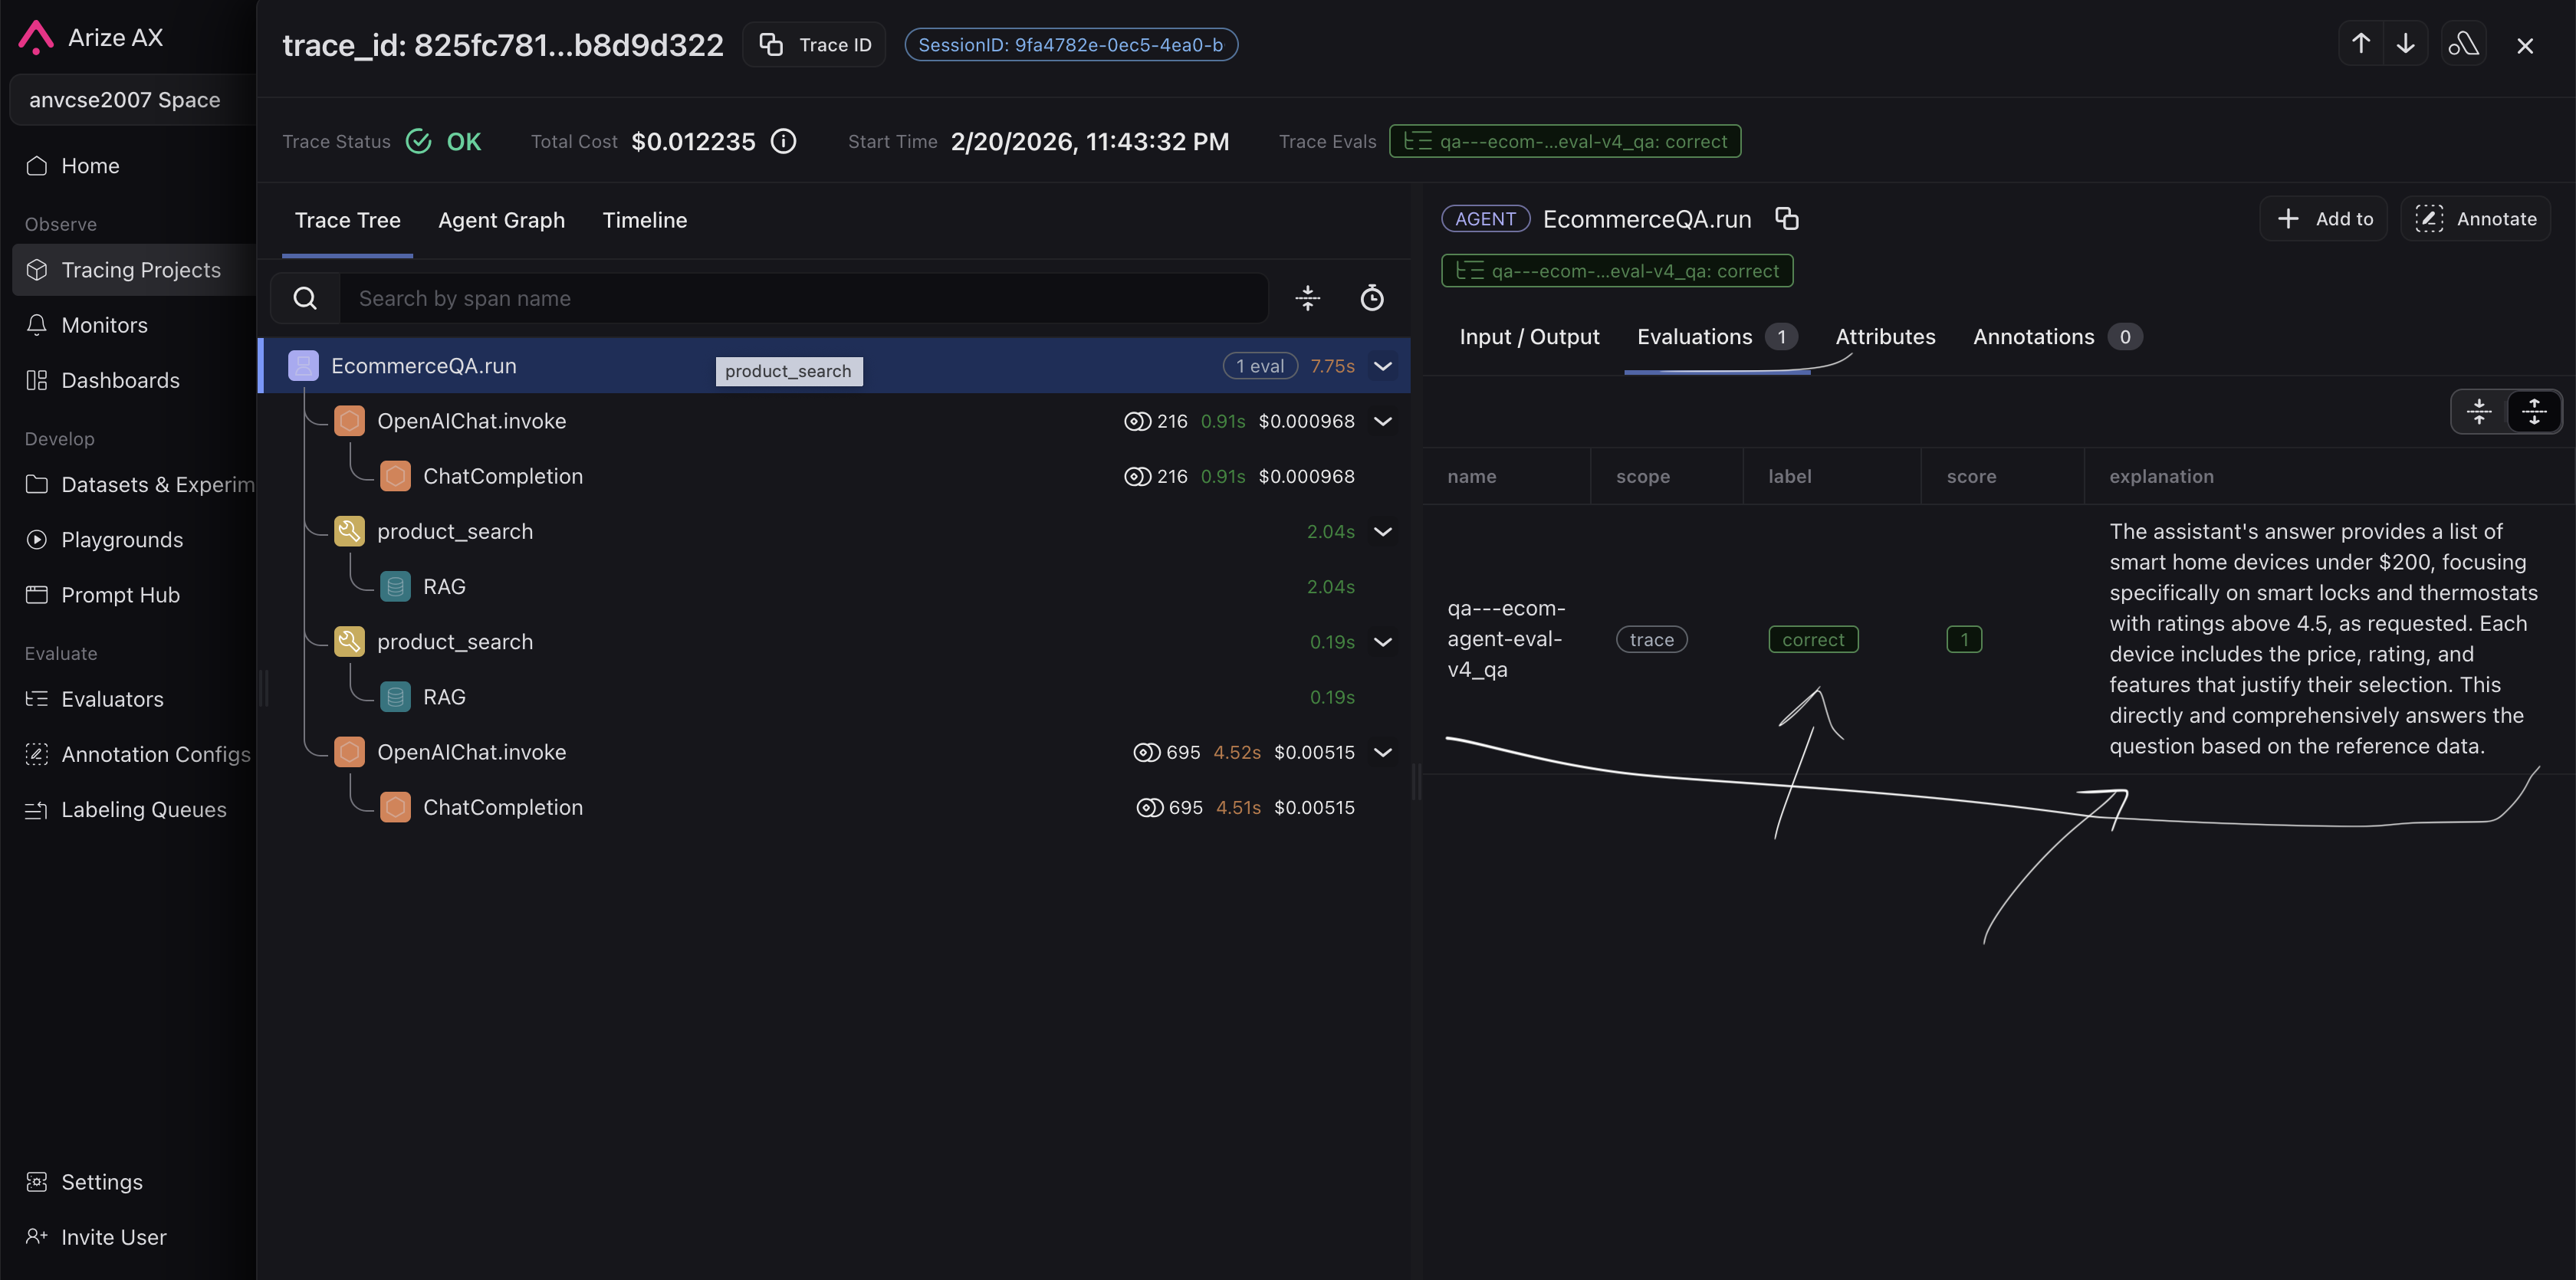